In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
X_train = pd.DataFrame(np.loadtxt("UCI HAR Dataset/train/X_train.txt"))
print(f"Количество признаков: {X_train.shape[1]}")

Количество признаков: 561


In [3]:
if X_train.isnull().values.any():
    print("В данных есть пропуски.")
else:
    print("Пропусков в данных нет.")

Пропусков в данных нет.


In [4]:
# Проверим различие признаков по масштабу на основе стандартного отклонения
feature_std = np.std(X_train, axis=0)
if np.any(feature_std > 0.5):
    print("Признаки отличаются по масштабу.")
else:
    print("Признаки имеют схожий масштаб.")

Признаки отличаются по масштабу.


In [5]:
# Понижение размерности методом порога отклонения
from sklearn.feature_selection import VarianceThreshold

threshold_percentage = 0.10  # 10%

threshold = np.quantile(np.var(X_train, axis=0), threshold_percentage)
var = VarianceThreshold(threshold=threshold)
X_train2 = var.fit_transform(X_train)
print(X_train2.shape)

(7352, 504)


In [6]:
# Воспользуемся методом PCA
from sklearn.decomposition import PCA

# Для начала отмасштабируем выборку
X_train2_norm = StandardScaler().fit_transform(X_train2)

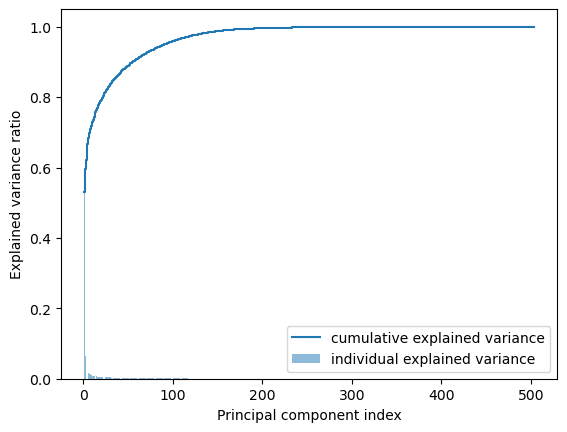

In [7]:
pca = PCA(n_components=X_train2_norm.shape[1])
pca.fit(X_train2_norm)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, X_train2_norm.shape[1] + 1), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1, X_train2_norm.shape[1] + 1), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [8]:
# Определение минимального необходимого количества главных компонент
min_components = np.argmax(cum_var_exp >= 0.9) + 1
print(f"Минимальное количество главных компонент для объяснения 90% дисперсии: {min_components}")

Минимальное количество главных компонент для объяснения 90% дисперсии: 56


In [9]:
# Выделение первых двух компонент и визуализация
pca2 = PCA(n_components=2)
X_train2_pca2 = pca2.fit_transform(X_train2_norm)

C:\Users\msi\AppData\Local\Temp\ipykernel_12852\1200989131.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train2_pca2[:, 0], X_train2_pca2[:, 1], cmap='viridis', alpha=0.5)


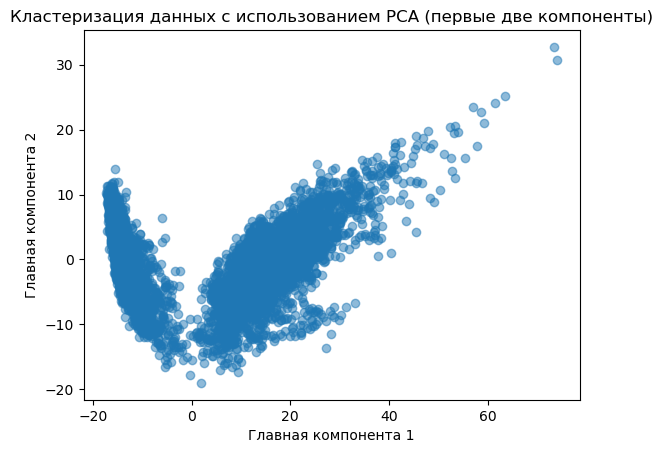

In [10]:
plt.scatter(X_train2_pca2[:, 0], X_train2_pca2[:, 1], cmap='viridis', alpha=0.5)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('Кластеризация данных с использованием PCA (первые две компоненты)')
plt.show()

In [11]:
# Оценка оптимального числа кластеров с использованием метода локтя
from sklearn.cluster import KMeans
from tqdm import tqdm

distortion = []
K = range(1, 10)
for k in tqdm(K):
    model = KMeans(n_clusters=k, random_state=4)
    model.fit(X_train2_pca2)
    distortion.append(model.inertia_) 

  0%|          | 0/9 [00:00<?, ?it/s]c:\Users\msi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 11%|█         | 1/9 [00:00<00:06,  1.25it/s]c:\Users\msi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 22%|██▏       | 2/9 [00:01<00:05,  1.23it/s]c:\Users\msi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 33%|███▎      | 3/9 [00:02<00:04,  1.26it/s]c:\Users\msi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will cha

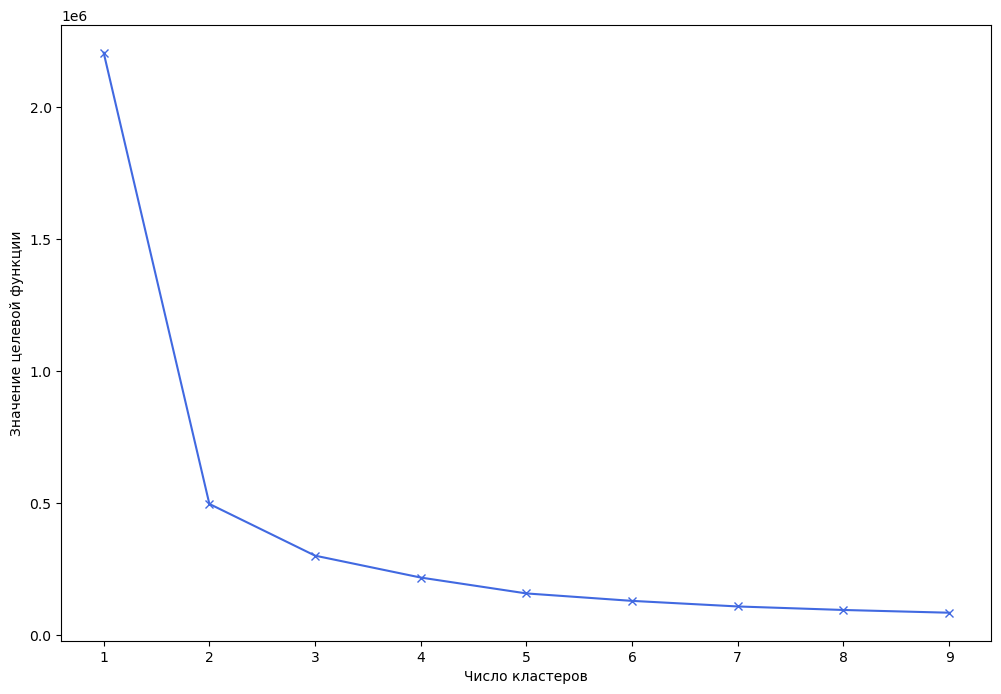

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, c='royalblue', marker='x')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show()

По диаграмме видно, что "сгиб локтя" находится на отметке 2, соответственно выбираем 2 кластера

c:\Users\msi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


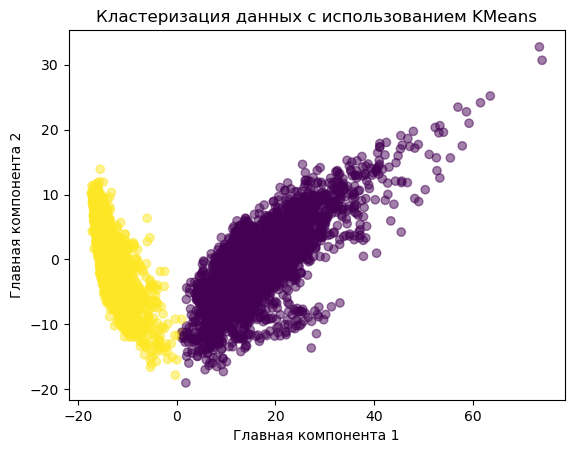

In [13]:
optimal_clusters = 2  # замените это значение на оптимальное, найденное по графику
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
labels = kmeans.fit_predict(X_train2_pca2)

# Визуализация данных по первым двум компонентам с разметкой кластеров
plt.scatter(X_train2_pca2[:, 0], X_train2_pca2[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('Кластеризация данных с использованием KMeans')
plt.show()

In [14]:
# Оценка качества кластеризации
# Загрузка данных
y_train = np.loadtxt('UCI HAR Dataset/train/y_train.txt')
activity_labels = pd.read_csv('UCI HAR Dataset/activity_labels.txt', sep=' ', header=None, names=['Activity_ID', 'Activity'])

In [15]:
df_results = pd.DataFrame({'Actual': activity_labels['Activity'][y_train.astype(int) - 1], 'Predicted': labels})
confusion_matrix = pd.crosstab(df_results['Actual'], df_results['Predicted'], margins=True)

print("Матрица ошибок:")
print(confusion_matrix)

Матрица ошибок:
Predicted              0     1   All
Actual                              
LAYING                11  1396  1407
SITTING                1  1285  1286
STANDING               0  1374  1374
WALKING             1226     0  1226
WALKING_DOWNSTAIRS   986     0   986
WALKING_UPSTAIRS    1068     5  1073
All                 3292  4060  7352


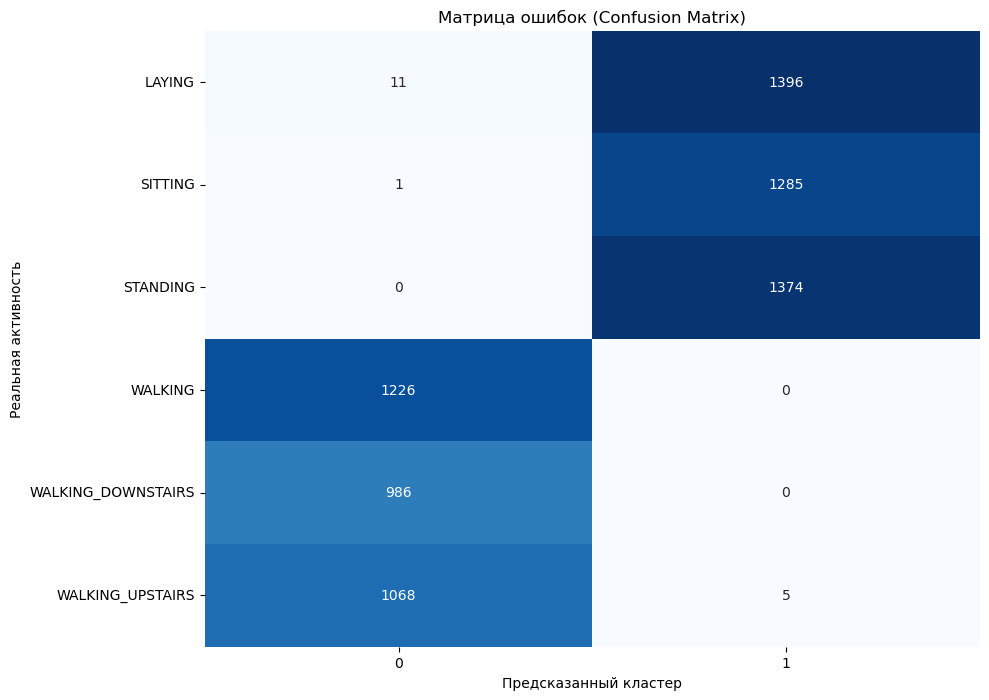

In [16]:
import seaborn as sns

# Построение тепловой карты для матрицы ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix.iloc[:-1, :-1], annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Предсказанный кластер')
plt.ylabel('Реальная активность')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.show()


Активности разделены по степени движения: пассивные активности типа LAYING, SITTING, STANDING отделены в кластер 1, 
активные активности типа WALKING, WALKING_DOWNSTAIRS и WALKING_UPSTAIRS отделены в кластер 0.